# Validation of effective Hamiltonian extraction

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rqutils.paulis as paulis
from rqutils.qprint import qprint
from rqutils.math import matrix_exp, matrix_angle
import qudit_sim
import qudit_sim.analysis

qudit_sim.config.jax_devices = [0, 1]

try:
    os.makedirs('heff_validation')
except OSError:
    pass

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [3]:
qudit_sim.analysis.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [4]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 10))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qubit_resonant')
qprint(components[0], 'pauli')

<IPython.core.display.Latex object>

In [5]:
qudit_sim.analysis.print_heff_fit_result(components)

<IPython.core.display.Latex object>

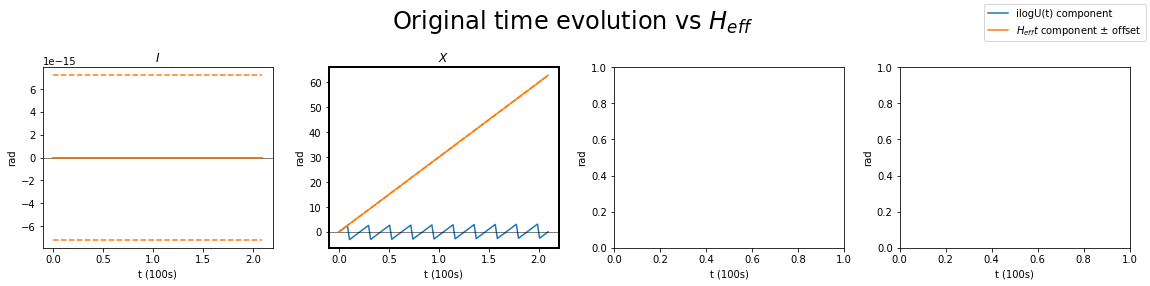

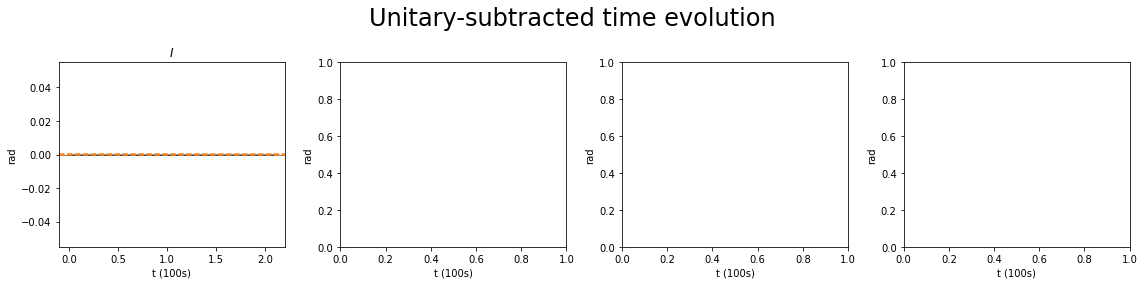

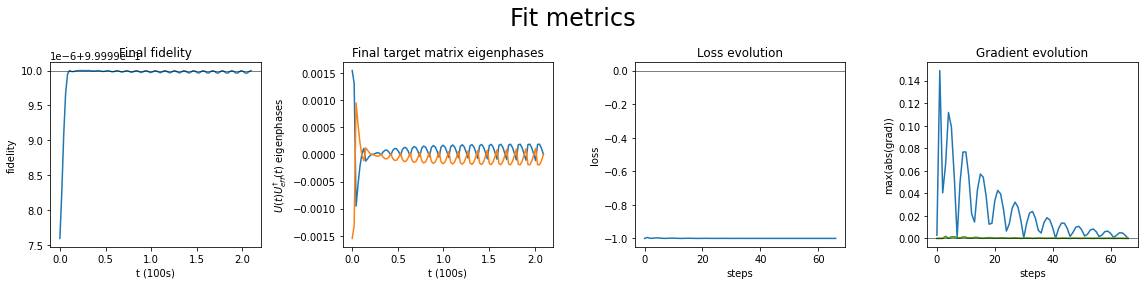

In [6]:
qudit_sim.analysis.inspect_heff_fit('heff_validation/single_qubit_resonant.h5');

## Single qubit off-resonant drive

In [7]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qubit_offresonant')

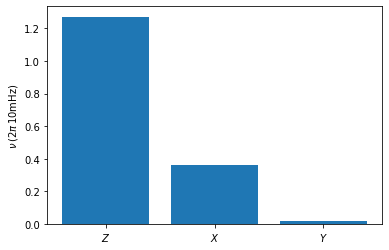

In [8]:
qudit_sim.analysis.plot_components(components[0], threshold=0.001);

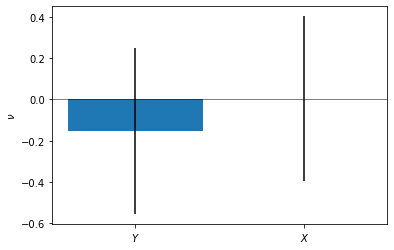

In [9]:
qudit_sim.analysis.plot_components(components[1], uncertainties=components[2], scale=None, threshold=0.001);

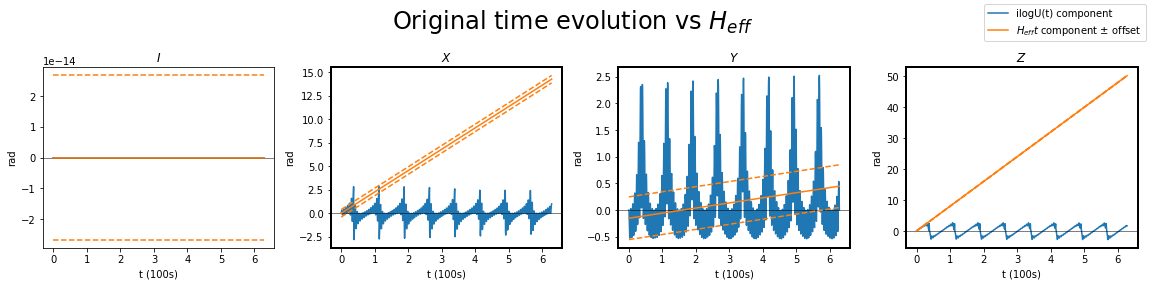

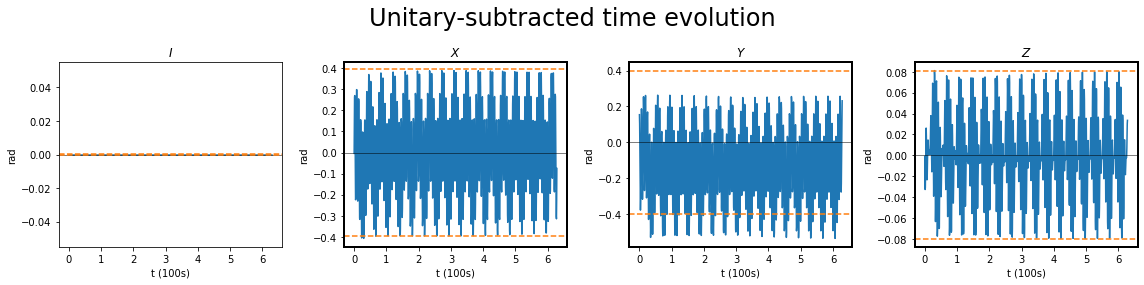

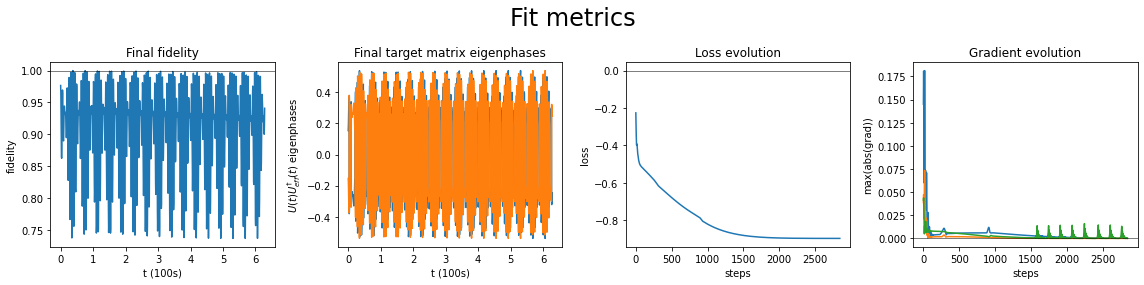

In [10]:
qudit_sim.analysis.inspect_heff_fit('heff_validation/single_qubit_offresonant.h5');

As in the validation of simulation, the drive-frame Hamiltonian is

In [11]:
hgen.set_frame('q0', frequency=np.full(1, 101.))
qudit_sim.analysis.print_hamiltonian(hgen.build())

<IPython.core.display.Latex object>

The qudit-frame time evolution is given by

$$
\begin{split}
T\left[\exp\left(-i \int_{t_0}^{t_1} dt H_{\mathrm{q.f.}}(t)\right) \right] & = U_q(t_1) U_d(t_1)^{\dagger} e^{-i H_{\mathrm{d.f.}}(t_1 - t_0)} U_d(t_0) U_q(t_0)^{\dagger} \\
& = \exp \left(-i \frac{\omega_q - \omega_d}{2} \sigma_z t_1 \right) e^{-i H_{\mathrm{d.f.}}(t_1 - t_0)} \exp \left(i \frac{\omega_q - \omega_d}{2} \sigma_z t_0 \right).
\end{split}
$$

Validate that a correct time evolution operator was passed to find_heff (this is rather a validation of the simulation part):

In [12]:
tlist = sim_result.times
hdf = hgen.build()[0].full()
udf = matrix_exp(-1.j * tlist[:, None, None] * hdf[None, ...], hermitian=-1)
sigmaz = paulis.paulis(2)[3]
uq_uddag = matrix_exp(-1.j * (100. - 101.) * 0.5 * tlist[:, None, None] * sigmaz[None, ...], hermitian=-1)
time_evolution = uq_uddag @ udf

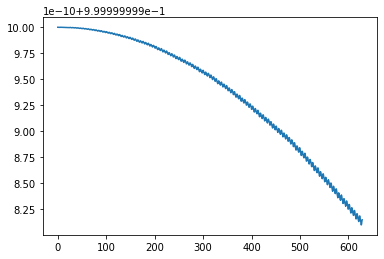

In [13]:
with h5py.File('heff_validation/single_qubit_offresonant.h5') as source:
    sim_time_evolution = source['time_evolution'][()]
    
plt.plot(tlist, np.abs(np.trace(time_evolution.transpose((0, 2, 1)).conjugate() @ sim_time_evolution, axis1=1, axis2=2)) / 2);

## Single qutrit qubit-resonant drive, qubit $H_{\mathrm{eff}}$ extraction

In [14]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [15]:
qudit_sim.analysis.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [16]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/single_qutrit_resonant')

In [17]:
qudit_sim.analysis.print_heff_fit_result(components, threshold=0.)

<IPython.core.display.Latex object>

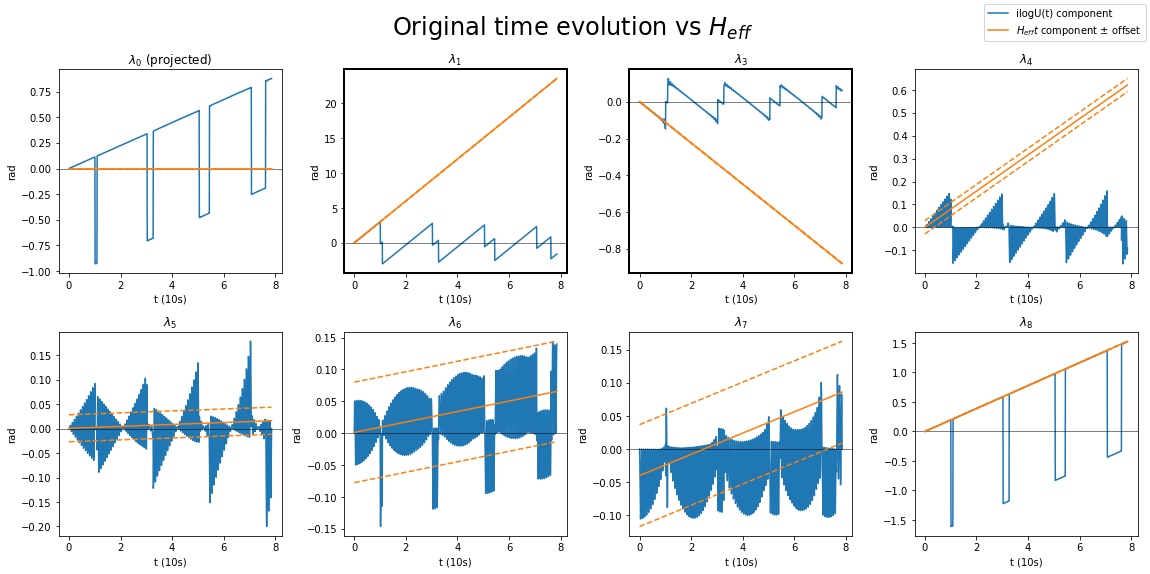

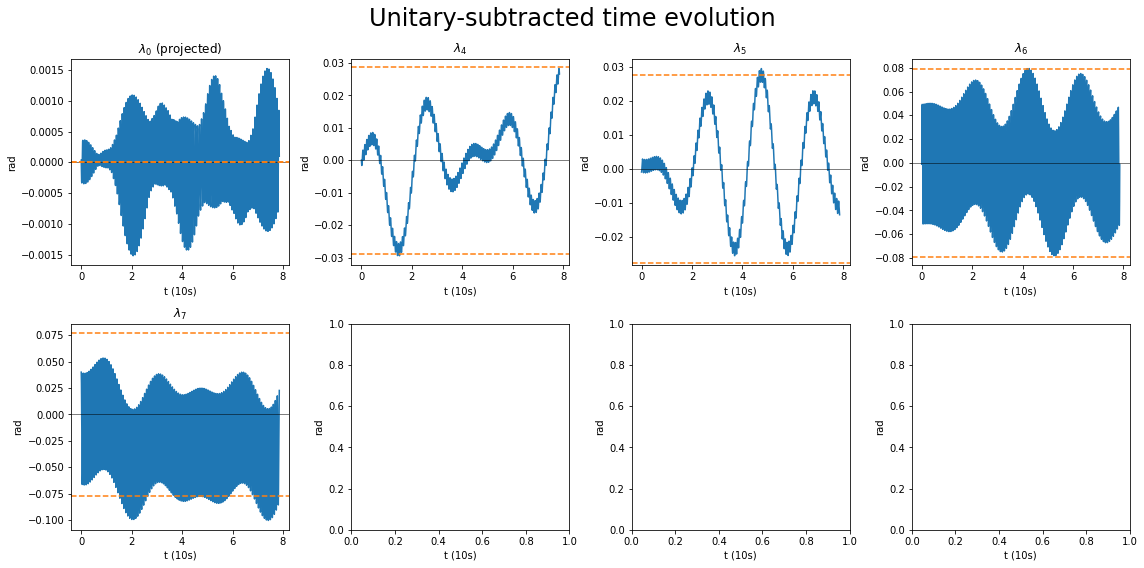

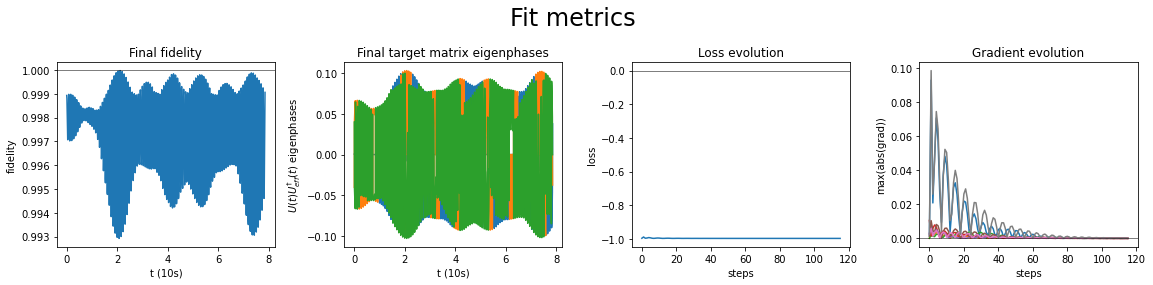

In [18]:
qudit_sim.analysis.inspect_heff_fit('heff_validation/single_qutrit_resonant.h5');

## Two qubit cross resonance, no crosstalk

In [19]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=0.2)

In [20]:
qudit_sim.analysis.print_hamiltonian(hgen.build(rwa=True))

<IPython.core.display.Latex object>

In [21]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 100))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/cross_resonance')

In [22]:
qudit_sim.analysis.print_heff_fit_result(components)

<IPython.core.display.Latex object>

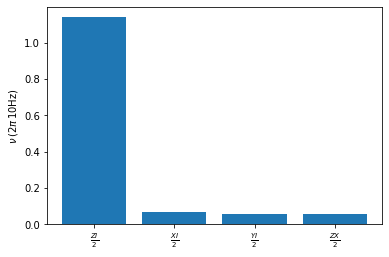

In [23]:
qudit_sim.analysis.plot_components(components[0]);

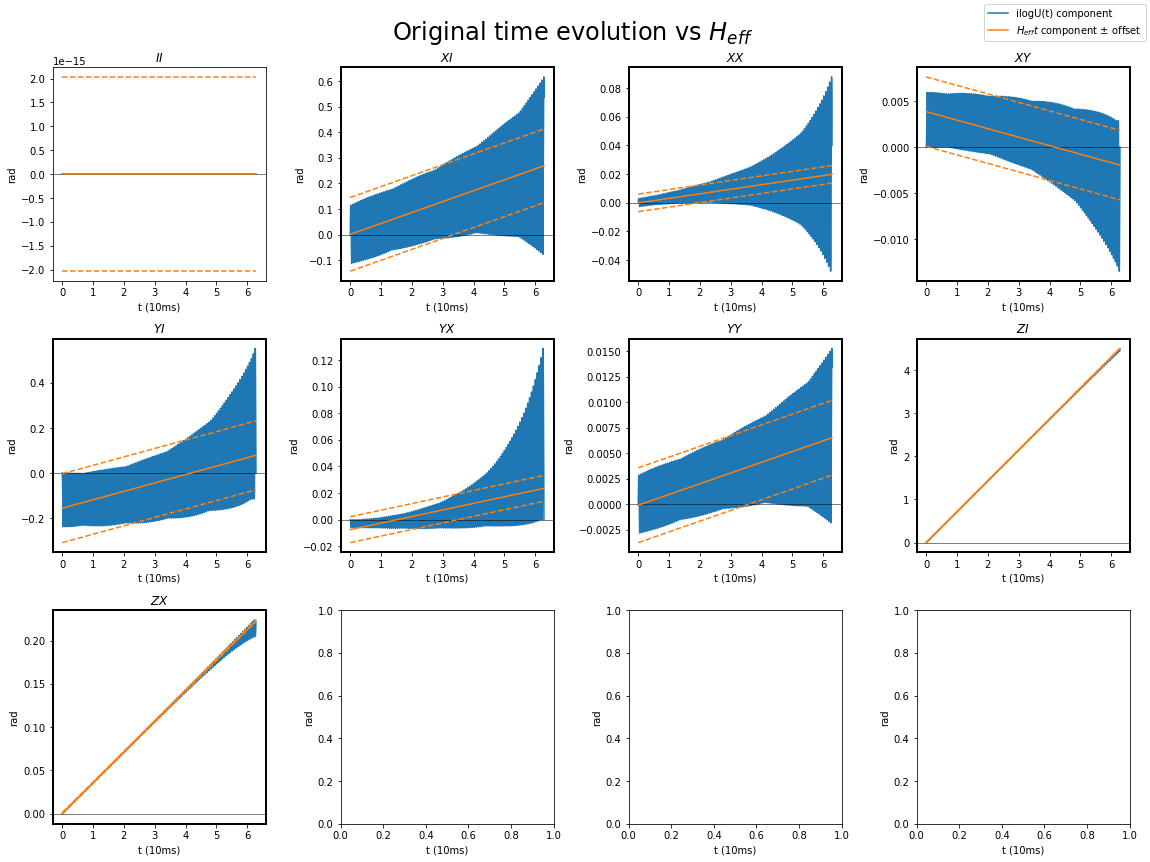

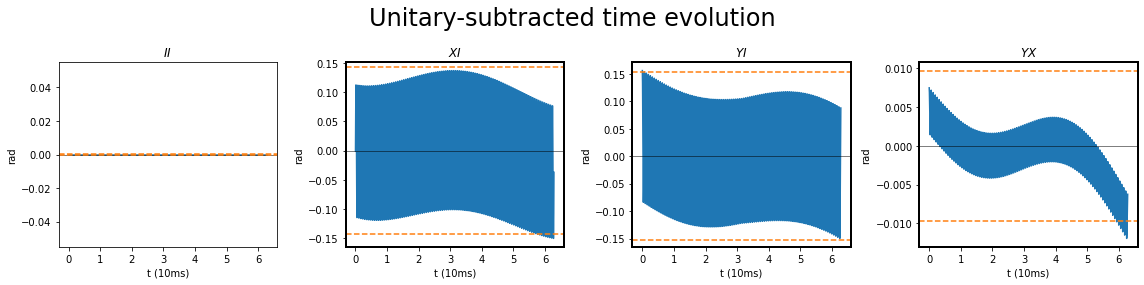

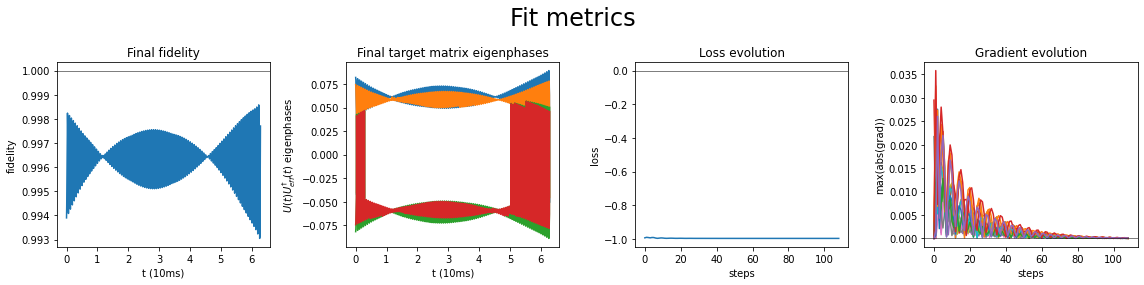

In [24]:
qudit_sim.analysis.inspect_heff_fit('heff_validation/cross_resonance.h5');

Run the simulation for different durations to estimate the uncertainties in $H_{\mathrm{eff}}$:

In [25]:
hgen.clear_drive()
components, uncertainties = qudit_sim.analysis.heff_analysis(hgen, [('q0', hgen.frame('q1').frequency[0], 0.2)])
qudit_sim.analysis.print_components(components[0], uncertainties[0])

<IPython.core.display.Latex object>

## Cross resonance amplitude scan

In [26]:
amplitudes = np.linspace(-0.5, 0.5, 20)

hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)

hgens = hgen.make_scan('amplitude', amplitudes, qudit_id='q0', frequency=hgen.frame('q1').frequency[0])

sim_results = qudit_sim.pulse_sim(hgens, tlist=(10, 100))
components_list = qudit_sim.find_heff(sim_results, save_result_to='heff_validation/cr_amplitude_scan')

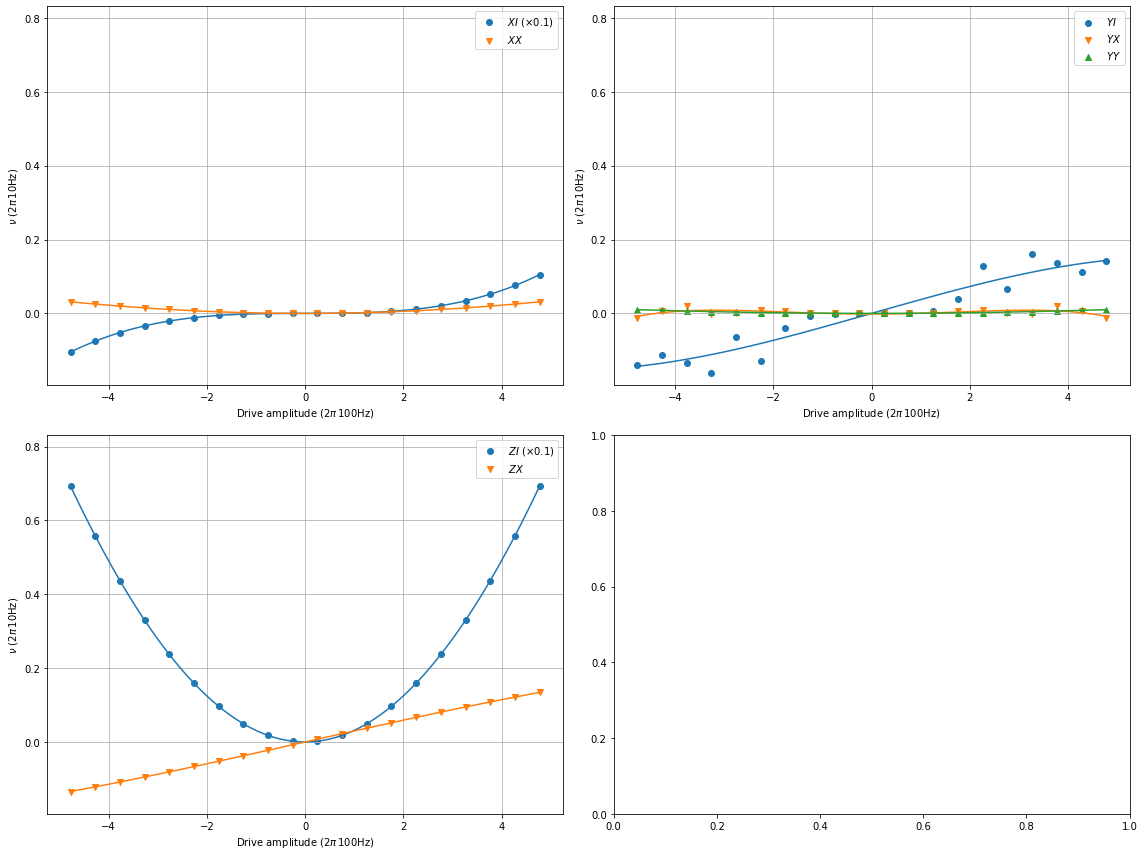

In [27]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude
fig, coefficients, amp_scale, compo_scale = qudit_sim.analysis.plot_amplitude_scan(physical_amplitudes, components_list)

In [28]:
qudit_sim.analysis.print_amplitude_scan(coefficients, amp_scale, compo_scale)

<IPython.core.display.Latex object>

## Two qutrit no drive

Using an unrealistically large coupling

In [29]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3000.)

In [30]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, 20))
components = qudit_sim.find_heff(sim_result, save_result_to='heff_validation/two_qutrit_hstat')

In [31]:
qudit_sim.analysis.print_heff_fit_result(components)

<IPython.core.display.Latex object>

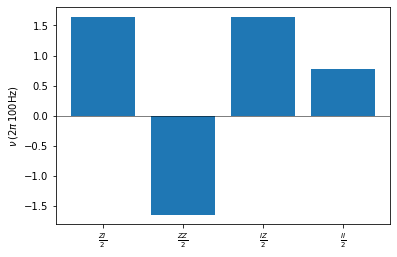

In [32]:
qudit_sim.analysis.plot_components(components[0]);

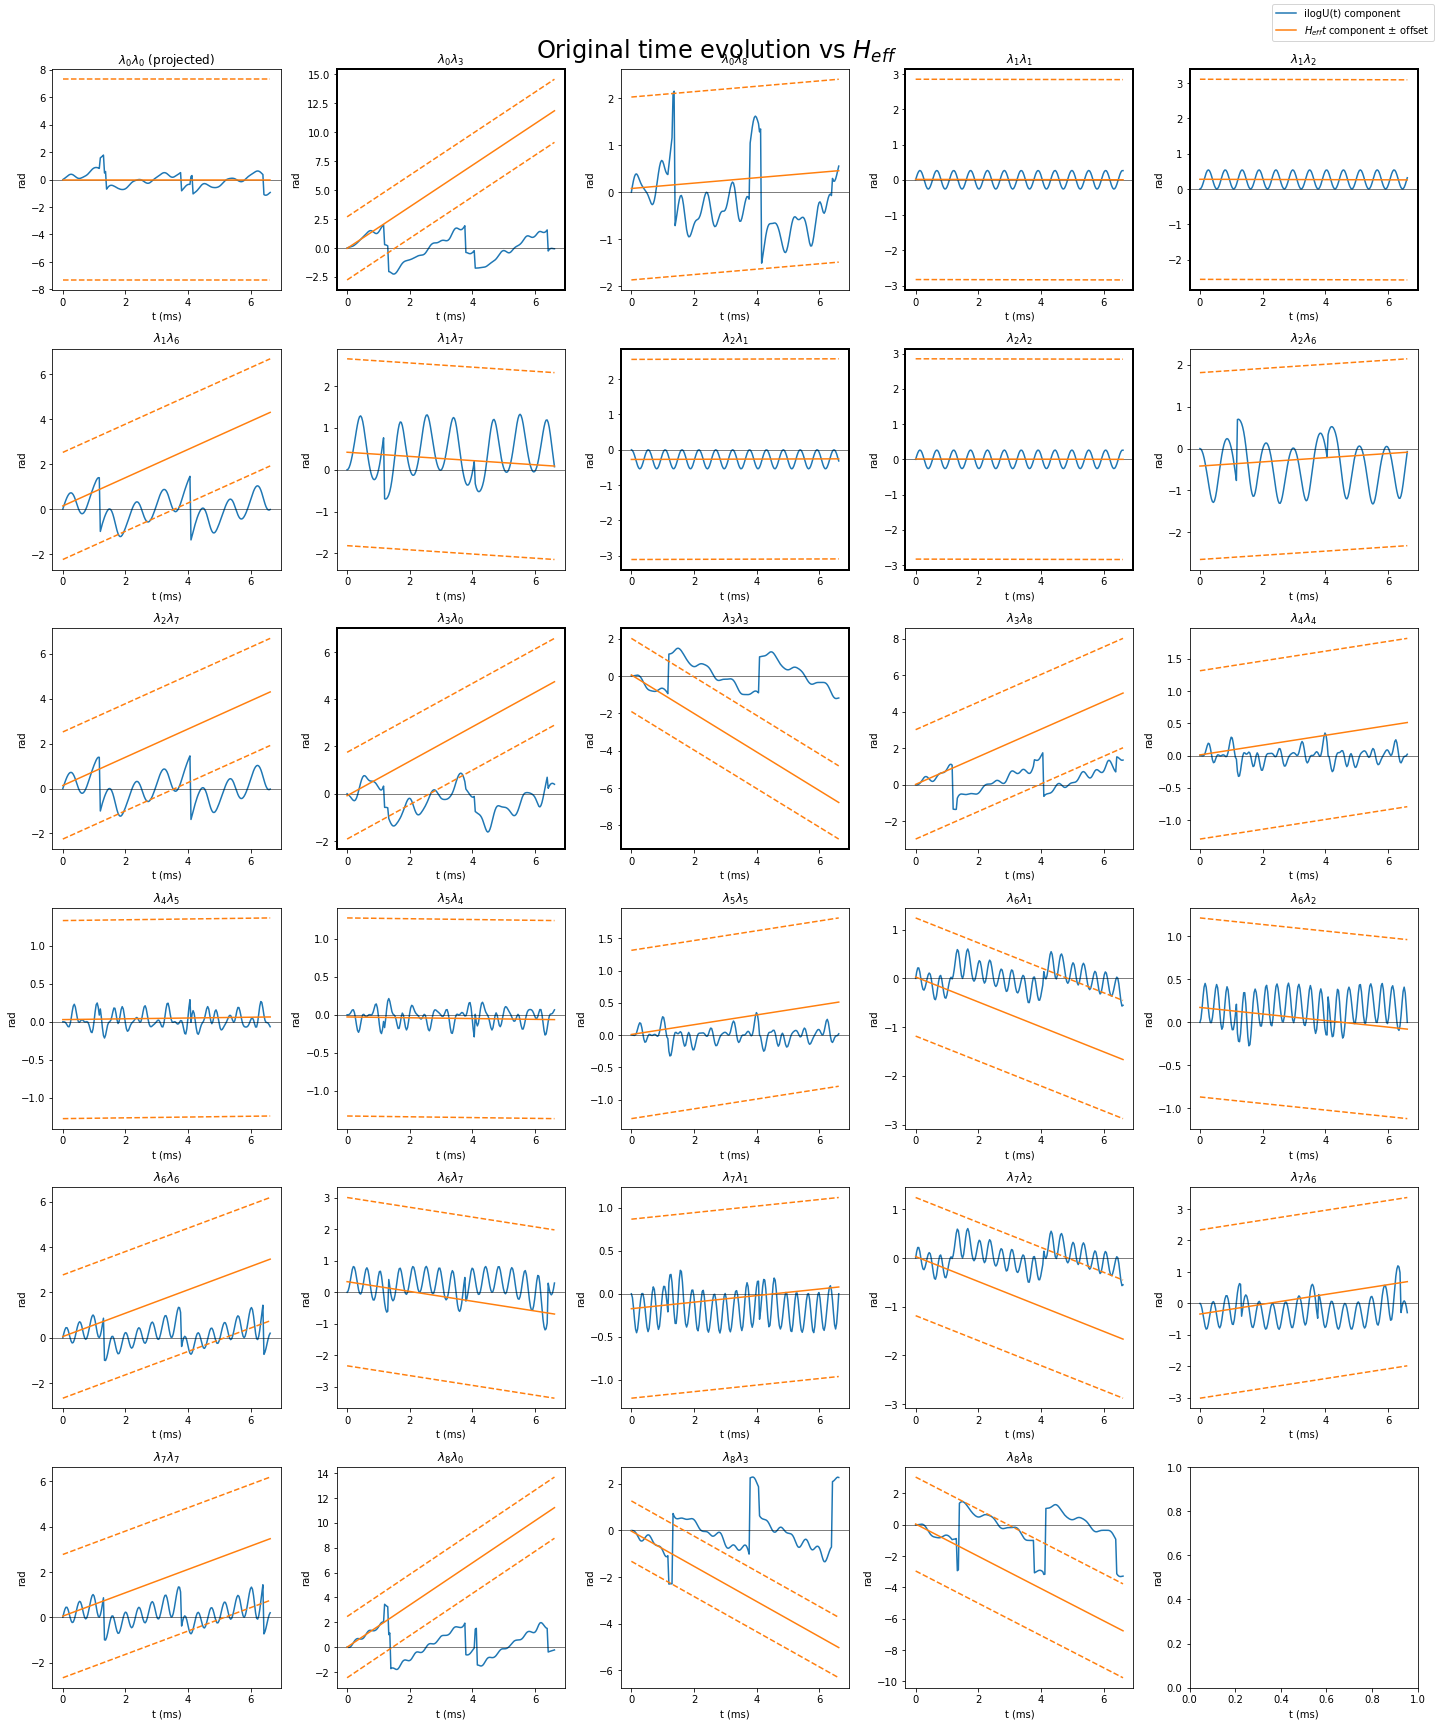

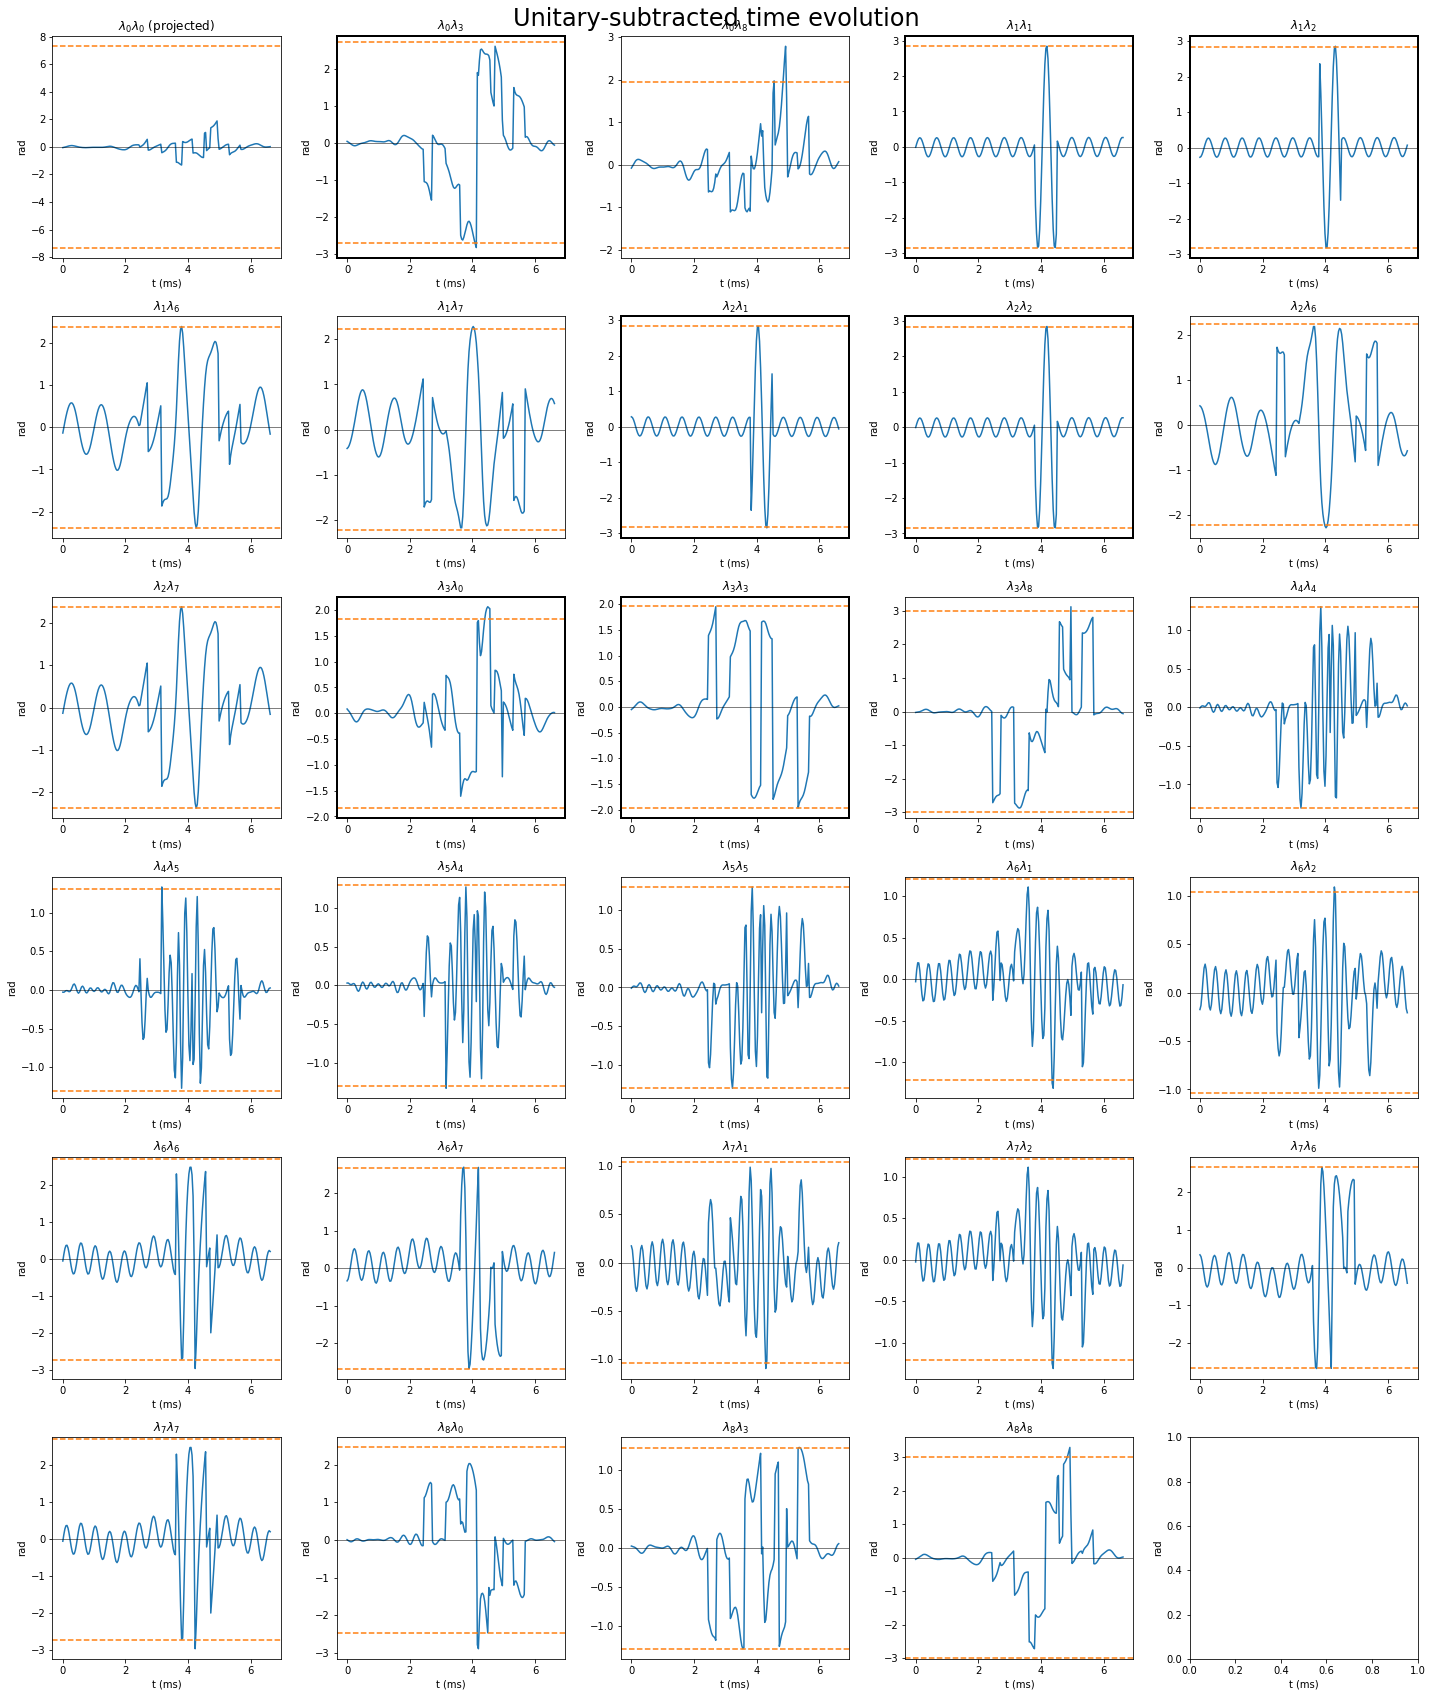

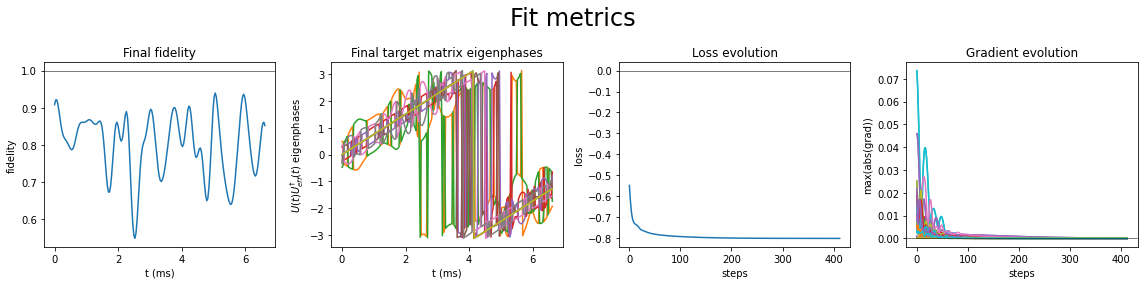

In [33]:
qudit_sim.analysis.inspect_heff_fit('heff_validation/two_qutrit_hstat.h5');